# Interprétation

Source : https://www.aquiladata.fr/insights/interpretabilite-des-modeles-de-machine-learning/

In [1]:
import os
os.chdir(os.path.dirname(os.getcwd()))
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from tqdm.notebook import trange, tqdm
import xgboost as xgb
import shap
from sklearn.inspection import permutation_importance
from sklearn.inspection import plot_partial_dependence, partial_dependence

from tools import Modelisation, datasets, convert_keys_to_int, PDF

# pdf = PDF('output/interpretation/')

shap.initjs()
t = time.time()

In [2]:
best_LR = "LR_RFECV"
best_RF = "Forest_RFECV"
best_XGB = "XGBoost_RFECV"

In [3]:
import json

# Régression logistique
with open('backups/RFECV_LR.json') as column_file:
    LR_COLUMNS = json.load(column_file)
    LR_COLUMNS_QUANT = LR_COLUMNS['columns_quant']
    LR_COLUMNS_CAT = LR_COLUMNS['columns_cat']
    LR_COLUMNS = LR_COLUMNS_QUANT + LR_COLUMNS_CAT

with open('backups/PARAMS_LR.json') as param_file:
    LR_PARAMS = json.load(param_file)[best_LR]
    LR_PARAMS = convert_keys_to_int(LR_PARAMS)

print(f'Variables explicatives régression logistique ({len(LR_COLUMNS)}) :')
display(LR_COLUMNS)

print(f'Meilleurs paramètres régression logistique ({len(LR_PARAMS)}) :')
display(LR_PARAMS)

# Forêt aléatoires
with open('backups/RFECV_Forest.json') as column_file:
    RF_COLUMNS = json.load(column_file)
    RF_COLUMNS_QUANT = RF_COLUMNS['columns_quant']
    RF_COLUMNS_CAT = RF_COLUMNS['columns_cat']
    RF_COLUMNS = RF_COLUMNS_QUANT + RF_COLUMNS_CAT

with open('backups/PARAMS_Forest.json') as param_file:
    RF_PARAMS = json.load(param_file)[best_RF]
    RF_PARAMS = convert_keys_to_int(RF_PARAMS)

print(f'Variables explicatives forêt aléatoires ({len(RF_COLUMNS)}) :')
display(RF_COLUMNS)

print(f'Meilleurs paramètres forêt aléatoires ({len(RF_PARAMS)}) :')
RF_PARAMS['class_weight'] = {int(k): v for k,v in RF_PARAMS['class_weight'].items()}
display(RF_PARAMS)

# XGBoost
with open('backups/RFECV_XGBoost.json') as column_file:
    XGB_COLUMNS = json.load(column_file)
    XGB_COLUMNS_QUANT = XGB_COLUMNS['columns_quant']
    XGB_COLUMNS_CAT = XGB_COLUMNS['columns_cat']
    XGB_COLUMNS = XGB_COLUMNS_QUANT + XGB_COLUMNS_CAT

with open('backups/PARAMS_XGBoost.json') as param_file:
    XGB_PARAMS = json.load(param_file)[best_XGB]
    XGB_PARAMS = convert_keys_to_int(XGB_PARAMS)

print(f'Variables explicatives XGBoost ({len(XGB_COLUMNS)}) :')
display(XGB_COLUMNS)

print(f'Meilleurs paramètres XGBoost ({len(XGB_PARAMS)}) :')
display(XGB_PARAMS)

# Seuils ajustés
with open('backups/THRESHOLD.json') as threshold_file:
    SEUILS = json.load(threshold_file)

print("Seuils ajustés :")
display(SEUILS)

Variables explicatives régression logistique (11) :


['campaignctrlast24h',
 'display_size',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'zonecostineuro',
 'campaignscenario_13',
 'device_type_Desktop',
 'device_type_iPhone',
 'display_env_app_ios',
 'is_interstitial_True',
 'target_env_2']

Meilleurs paramètres régression logistique (2) :


{'C': 0.007278953843983146, 'class_weight': {0: 1, 1: 20}}

Variables explicatives forêt aléatoires (9) :


['campaignctrlast24h',
 'contextid',
 'dayssincelastvisitdouble',
 'display_size',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'zonecostineuro',
 'is_interstitial_True']

Meilleurs paramètres forêt aléatoires (8) :


{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'class_weight': {0: 1, 1: 32},
 'bootstrap': False,
 'n_jobs': -1}

Variables explicatives XGBoost (9) :


['campaignctrlast24h',
 'contextid',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'zonecostineuro',
 'device_type_Android',
 'device_type_Desktop',
 'device_type_iPad',
 'is_interstitial_True']

Meilleurs paramètres XGBoost (11) :


{'subsample': 1.0,
 'scale_pos_weight': 16.5,
 'n_estimators': 100,
 'min_child_weight': 3,
 'max_depth': 2,
 'learning_rate': 0.1,
 'gamma': 1.5,
 'colsample_bytree': 0.6,
 'booster': 'gbtree',
 'objective': 'binary:logistic',
 'n_jobs': -1}

Seuils ajustés :


{'LR': 0.5005859374999999,
 'Forest': 0.6492187500000004,
 'XGBoost': 0.4799804687499999}

# 1. Régression logistique

In [4]:
df_train = pd.read_csv('data/df_train_prepro.csv').sample(frac=1, random_state=1234)
df_test = pd.read_csv('data/df_test_prepro.csv').sample(frac=1, random_state=1234)
datasets_df_train = datasets(df_train, columns_quant=LR_COLUMNS_QUANT, columns_cat=LR_COLUMNS_CAT, drop='first', verbose=False)
datasets_df_test = datasets(df_test, columns_quant=LR_COLUMNS_QUANT, columns_cat=LR_COLUMNS_CAT, drop='first', verbose=False)
X_train = datasets_df_train['X_only_quant_scaled']
y_train = datasets_df_train['y']
X_test = datasets_df_test['X_only_quant_scaled']
y_test = datasets_df_test['y']

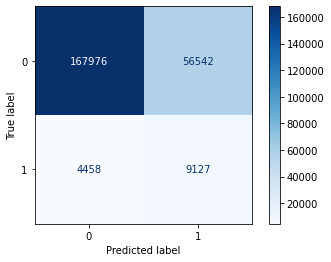

f1 : 0.2303
f3 : 0.4856
f5 : 0.5855
recall : 0.6718
negative predictive value : 0.9741
precision : 0.1390
roc_auc : 0.7771
training time : 2.186s
prediction time : 0.03s


In [5]:
m = Modelisation(X_train, y_train, LogisticRegression(**LR_PARAMS), X_test=X_test, y_test=y_test, seuil=SEUILS['LR'])
m.show_conf_matrix()
m.show_metrics_score()

In [6]:
coeffs = pd.DataFrame({"Feature": X_train.columns.tolist(),"Coefficients": m.model.coef_[0]})
coeffs.sort_values(by="Coefficients", ascending = False)

,Feature,Coefficients
4,zonecostineuro,0.762348
0,campaignctrlast24h,0.318018
9,is_interstitial_True,0.241982
1,display_size,0.152171
8,display_env_app_ios,0.072239
10,target_env_2,-0.073403
2,nbdayssincelastclick,-0.092570
5,campaignscenario_13,-0.133118
7,device_type_iPhone,-0.143667
3,nbdisplay_1hour,-0.151742


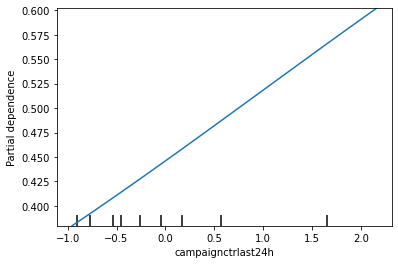

In [7]:
plot_partial_dependence(m.model, X_train, [0])

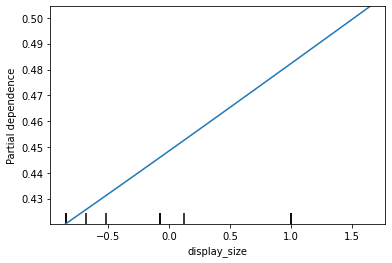

In [8]:
plot_partial_dependence(m.model, X_train, [1])

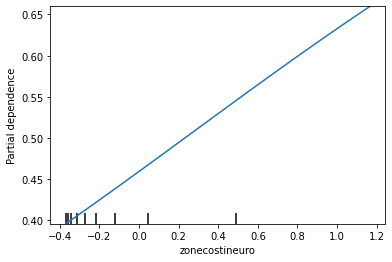

In [9]:
plot_partial_dependence(m.model, X_train, [4])

In [10]:
# get the partial dependence
partial_dependence(m.model, X_train, [0])

/usr/local/lib/python3.8/site-packages/sklearn/inspection/_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


(array([[0.37950065, 0.38162156, 0.38374777, 0.38587921, 0.3880158 ,
         0.39015748, 0.39230417, 0.39445582, 0.39661234, 0.39877366,
         0.4009397 , 0.4031104 , 0.40528568, 0.40746546, 0.40964967,
         0.41183823, 0.41403105, 0.41622807, 0.4184292 , 0.42063436,
         0.42284348, 0.42505646, 0.42727323, 0.4294937 , 0.43171779,
         0.43394542, 0.4361765 , 0.43841095, 0.44064868, 0.4428896 ,
         0.44513363, 0.44738068, 0.44963066, 0.45188348, 0.45413905,
         0.45639729, 0.4586581 , 0.46092139, 0.46318707, 0.46545505,
         0.46772524, 0.46999755, 0.47227187, 0.47454812, 0.47682621,
         0.47910604, 0.48138751, 0.48367054, 0.48595502, 0.48824086,
         0.49052797, 0.49281625, 0.4951056 , 0.49739593, 0.49968714,
         0.50197913, 0.5042718 , 0.50656507, 0.50885883, 0.51115299,
         0.51344744, 0.51574209, 0.51803684, 0.52033159, 0.52262625,
         0.52492072, 0.5272149 , 0.52950868, 0.53180199, 0.5340947 ,
         0.53638674, 0.53867799, 0

## 2. Random Forest

In [11]:
df_train = pd.read_csv('data/df_train_prepro.csv').sample(frac=0.1, random_state=1234)
df_test = pd.read_csv('data/df_test_prepro.csv').sample(frac=0.5, random_state=1234)
datasets_df_train = datasets(df_train, columns_quant=RF_COLUMNS_QUANT, columns_cat=RF_COLUMNS_CAT, verbose=False)
datasets_df_test = datasets(df_test, columns_quant=RF_COLUMNS_QUANT, columns_cat=RF_COLUMNS_CAT, verbose=False)
X_train = datasets_df_train['X']
y_train = datasets_df_train['y']
X_test = datasets_df_test['X']
y_test = datasets_df_test['y']

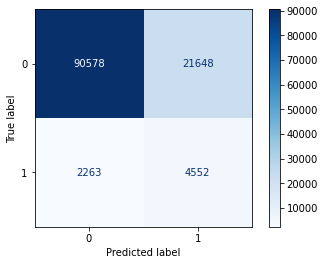

f1 : 0.2758
f3 : 0.5200
f5 : 0.6021
recall : 0.6679
negative predictive value : 0.9756
precision : 0.1737
roc_auc : 0.8175
training time : 28.425s
prediction time : 1.032s


In [12]:
m = Modelisation(X_train, y_train, RandomForestClassifier(**RF_PARAMS), X_test=X_test, y_test=y_test, seuil=SEUILS['Forest'])
m.show_conf_matrix()
m.show_metrics_score()

### Interprétation 

**Mean decrease in impurity**

In [13]:
def plot_mdi_importance(rf_model, features=X_train.columns):
    tree_feature_importances = (rf_model.feature_importances_)
    sorted_idx = tree_feature_importances.argsort()
    y_ticks = np.arange(0, len(features))
    fig, ax = plt.subplots()
    ax.barh(y_ticks, tree_feature_importances[sorted_idx])
    ax.set_yticklabels(pd.Series(features)[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_title("Random Forest Feature Importances (MDI)")
    fig.tight_layout()
    plt.show()

<ipython-input-13-098ee7b63768>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(pd.Series(features)[sorted_idx])


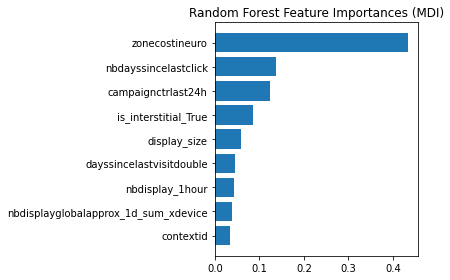

In [14]:
plot_mdi_importance(m.model)

In [15]:
def plot_permutation_importance(rf_model, X, y):
    result = permutation_importance(rf_model, X, y, n_repeats=5,
                                    random_state=1234, n_jobs=-1)
    sorted_idx = result.importances_mean.argsort()

    fig, ax = plt.subplots()
    ax.boxplot(result.importances[sorted_idx].T,
               vert=False, labels=X.columns[sorted_idx])
    ax.set_title("Permutation Importances")
    fig.tight_layout()
    plt.show()

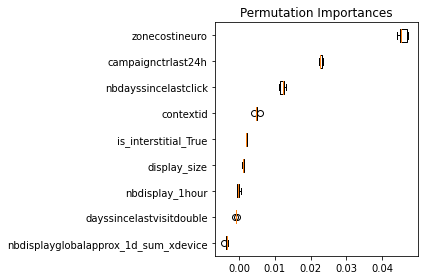

In [16]:
plot_permutation_importance(m.model, X_train, y_train)

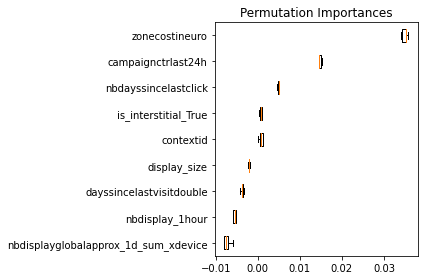

In [17]:
plot_permutation_importance(m.model, X_test, y_test)

### SHAP

In [18]:
X_train_sample = X_train.sample(1000)
X_test_sample = X_test.sample(1000)
explainer = shap.TreeExplainer(m.model)
shap_values_train = explainer.shap_values(X_train_sample.values)
shap_values_val = explainer.shap_values(X_test_sample.values)

Exception: Model type not yet supported by TreeExplainer: <class 'sklearn.ensemble._forest.RandomForestClassifier'>

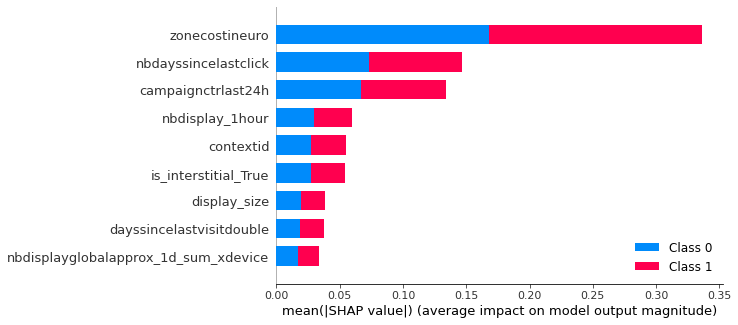

In [19]:
shap.summary_plot(shap_values_train, X_train_sample, plot_type="bar")

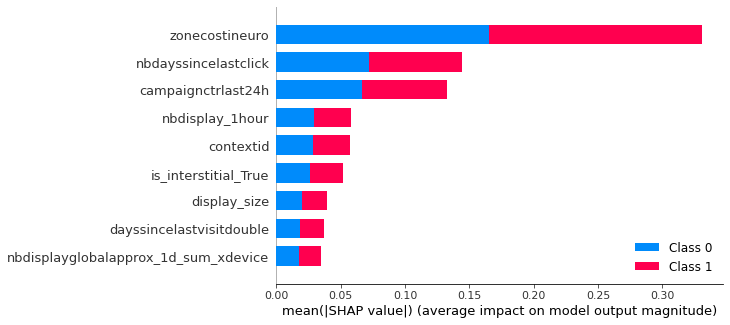

In [20]:
shap.summary_plot(shap_values_val, X_test_sample, plot_type="bar")

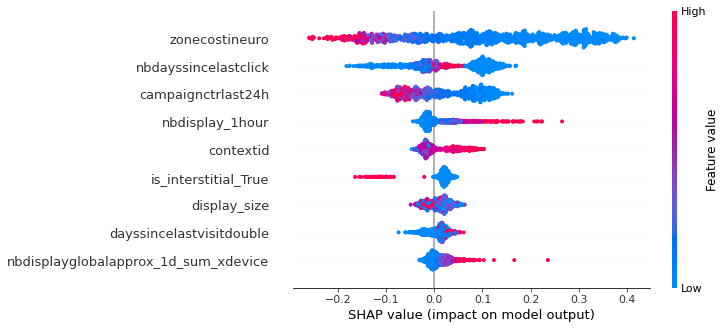

In [21]:
shap.summary_plot(shap_values_val[0], X_test_sample)

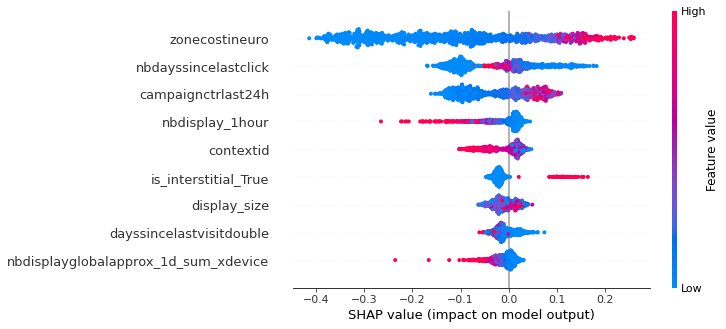

In [22]:
shap.summary_plot(shap_values_val[1], X_test_sample)

In [23]:
def shap_multiclass(idx, data='train'):
    if data=='train':
        y = y_train
        X = X_train_sample
        shap_values = shap_values_train
    elif data=='val':
        y = y_val
        X = X_val_sample
        shap_values = shap_values_val
    #idx = X.index[idx]
    print (idx)
    print ("y réel : "+str(y.iloc[idx]))
    print ("y prédit : "+str(m.model.predict(X.iloc[idx, :].values.reshape(1, -1))))
    for i in [0,1]:
        print (f'classe {i}')
        display(shap.force_plot(explainer.expected_value[i], shap_values[i][idx, :], X.iloc[idx, :]))

In [24]:
shap_multiclass(50,'train')

50
y réel : 0
y prédit : [1]
classe 0


classe 1


In [25]:
shap_multiclass(51,'train')

51
y réel : 0
y prédit : [1]
classe 0


classe 1


## 3. XGBoost

In [26]:
df_train = pd.read_csv('data/df_train_prepro.csv').sample(frac=1, random_state=1234)
df_test = pd.read_csv('data/df_test_prepro.csv').sample(frac=1, random_state=1234)
datasets_df_train = datasets(df_train, columns_quant=XGB_COLUMNS_QUANT, columns_cat=XGB_COLUMNS_CAT, verbose=False)
datasets_df_test = datasets(df_test, columns_quant=XGB_COLUMNS_QUANT, columns_cat=XGB_COLUMNS_CAT, verbose=False)
X_train = datasets_df_train['X']
y_train = datasets_df_train['y']
X_test = datasets_df_test['X']
y_test = datasets_df_test['y']

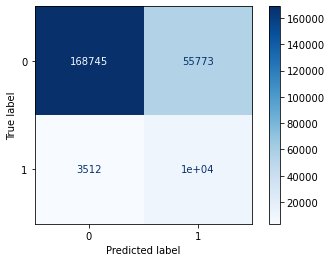

f1 : 0.2536
f3 : 0.5355
f5 : 0.6459
recall : 0.7415
negative predictive value : 0.9796
precision : 0.1530
roc_auc : 0.8257
training time : 19.318s
prediction time : 0.169s


In [27]:
m = Modelisation(X_train, y_train, XGBClassifier(**XGB_PARAMS), X_test=X_test, y_test=y_test, seuil=SEUILS['XGBoost'])
m.show_conf_matrix()
m.show_metrics_score()

### Interprétation 

**Feature importance : weight**

Il s’agit du nombre de fois où une variable est utilisée pour diviser les données à travers l’ensemble des arbres.

Text(0.5, 1.0, 'feature importance : weight')

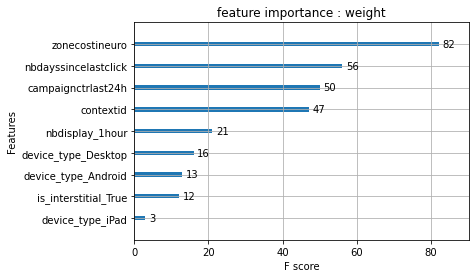

In [28]:
xgb.plot_importance(m.model)
plt.title("feature importance : weight")

**Feature importance : cover**

Il s’agit du nombre de fois où une variable est utilisée pour diviser les données à travers l’ensemble des arbres, pondéré par le nombre de données (d’entraînement) passées par ce noeud. On peut en effet avoir des noeuds créés lors de l’entraînement, mais où presque aucune donnée ne circule : on considère donc que l’influence de ce noeud est moindre.

Text(0.5, 1.0, 'feature importance : cover')

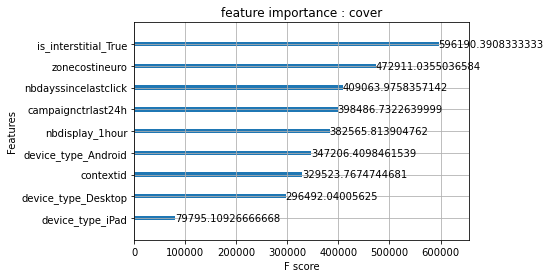

In [29]:
xgb.plot_importance(m.model, importance_type="cover")
plt.title("feature importance : cover")

**Feature importance : gain**

Il s’agit de la moyenne de la réduction de la fonction coût (pour les données d’entraînement) quand une variable est utilisée pour une division au niveau d’un noeud.

Text(0.5, 1.0, 'feature importance : gain')

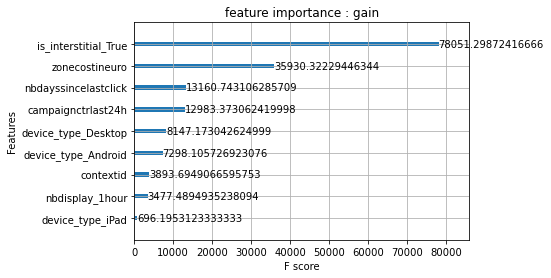

In [30]:
xgb.plot_importance(m.model, importance_type="gain")
plt.title("feature importance : gain")

In [31]:
print(f"Durée totale d'exécution : {time.strftime('%H:%M:%S', time.gmtime(time.time() - t))}")

Durée totale d'exécution : 00:09:09
